# Домашнее задание 1. Autoencoders & Frechet Inception Distance


В этом домашнем задании вам предлагается вспомнить то, что происходило на семинарах 1-2, написать свой автоэнкодер на CIFAR10 и использовать эмбеддинги от этого автоэнкодера чтобы посчитать Frechet Inception Distance (FID) между разными классами в CIFAR10

In [1]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
from sklearn.ensemble import GradientBoostingClassifier
from collections import defaultdict
import seaborn as sns

Будем использовать torchvision для работы с данными.

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x * 2) - 1
])

In [3]:
train_dataset = datasets.CIFAR10(
    './cifar',
    train=True,
    transform=transform,
    download=True)
val_dataset = datasets.CIFAR10(
    './cifar',
    train=False,
    transform=transform,
    download=True)
len(train_dataset), len(val_dataset)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar/cifar-10-python.tar.gz to ./cifar
Files already downloaded and verified


(50000, 10000)

Раз мы используем нормализацию картинок, то чтобы их нарисовать - надо их обратно разнормализировать

In [4]:
def denormalize_image(image):
    return (image + 1) / 2

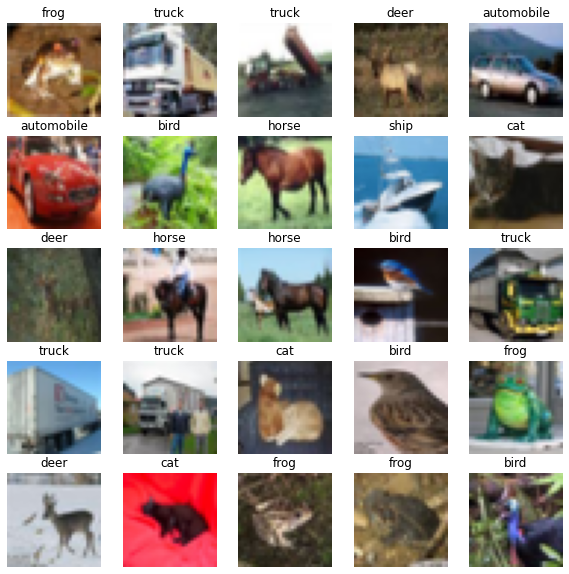

In [5]:
text_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10, 10))
for index, (image, label) in enumerate(train_dataset):
    plt.subplot(5, 5, index + 1)
    plt.imshow(denormalize_image(image.permute(1, 2, 0)))
    plt.axis('off')
    plt.title(text_labels[label])
    if index == 24: break
plt.show()

Размерность картинок: 3 канала 32х32 пикселя

In [6]:
image.shape

torch.Size([3, 32, 32])

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
len(train_loader), len(val_loader)

(1563, 10000)

### Задание 1. Обучить AE (3 балла)

Постройте свой AE, можете использовать любые блоки которые вам кажутся необходимыми.

<img src='https://miro.medium.com/max/1400/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png' width=500>

Напишите классы Encoder и Decoder

хинт: вам пригодятся nn.AvgPool2d/nn.MaxPool2d/Conv2d в энкодере и nn.Upsample/nn.ConvTranspose2d в декодере

In [8]:
class Block(nn.Module):
    def __init__(self, in_features, out_features, kernel, padding, stride=1, bias=False, enc = True):
        super().__init__()
        self.enc = enc

        self.conv = nn.Conv2d(in_features, out_features, kernel, stride=stride, padding=padding, bias=bias)
        #self.norm = nn.BatchNorm2d(out_features)
        self.act = nn.ReLU()
        self.norm = nn.BatchNorm2d(out_features)
        self.maxpool = nn.MaxPool2d(2, 2) 
        #self.act = nn.LeakyReLU(0.2)

        self.convtransp = nn.ConvTranspose2d(in_features, out_features, kernel, stride=stride, padding=padding, bias=bias)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False, 
                                                 recompute_scale_factor=False)
        
    def forward(self, x):
        if self.enc:
            return self.norm(self.maxpool(self.act(self.conv(x))))
        else:
            return self.norm(self.act(self.convtransp(self.upsample(x))))

In [9]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.encoder = nn.Sequential(
            Block(3, 16, 3, padding=1),       # [batch, 16, 16, 16]  
            Block(16, 32, 3, padding=1),      # [batch, 32, 8, 8]  
            Block(32, 64, 3, padding=1),      # [batch, 64, 4, 4]  
            Block(64, 128, 3, padding=1),      # [batch, 128, 2, 2] 
            #Block(64, 128, 3, padding=1).conv      # [batch, 128, 2, 2]  
        )

        ### END SOLUTION
    def forward(self, x):
        ### BEGIN SOLUTION
        x = self.encoder(x)
        ### END SOLUTION
        x = x.view(-1, 128*2*2)
        return x

In [10]:
encoder = Encoder()
noise = torch.rand(1, 3, 32, 32) - 1
assert np.array(encoder(noise).view(-1).shape)[0] < 1*3*32*32

In [11]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        self.decoder = nn.Sequential(
            #Block(128, 64, 3, padding=1, enc=False).convtransp,   # [batch, 64, 2, 2]  
            Block(128, 64, 3, padding=1, enc=False),   # [batch, 64, 4, 4]  
            Block(64, 32, 3, padding=1, enc=False),   # [batch, 32, 8, 8]   
            Block(32, 16, 3, padding=1, enc=False),   # [batch, 16, 16, 16]  
            Block(16, 3, 3, padding=1, enc=False)   # [batch, 3, 32, 32] 
        )
        ### END SOLUTION
    def forward(self, x):
        ### BEGIN SOLUTION
        x = x.view(-1, 128, 2, 2)
        x = self.decoder(x)
        ### END SOLUTION
        return x

In [12]:
decoder = Decoder()
noise = torch.rand(1, 3, 32, 32)
emb = encoder(noise)
assert decoder(emb).shape == (1, 3, 32, 32)

Посчитаем скор классификации картинок по эмбеддингам необученного энкодора, и в конце сравним с обученным. Для ускорения расчета, мы используем только часть трейна.

In [13]:
def classification_score(encoder, _train_dataset, val_dataset, device):
    encoder.eval()
    torch.manual_seed(0)
    train_dataset = Subset(_train_dataset, torch.randperm(len(_train_dataset))[:5000])
    X_train = []
    y_train = []
    for image, label in tqdm(train_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_train.append(emb.cpu().numpy().reshape(-1))
        y_train.append(label)
    X_train = np.stack(X_train)
    y_train = np.stack(y_train)
    clf = GradientBoostingClassifier(n_estimators=50, max_depth=5, verbose=1, random_state=0)
    clf.fit(X_train, y_train)
    X_val = []
    y_val = []
    for image, label in tqdm(val_dataset):
        image = image.to(device)
        with torch.no_grad():
            emb = encoder(image[None, ...])
        X_val.append(emb.cpu().numpy().reshape(-1))
        y_val.append(label)
    X_val = np.stack(X_val)
    y_val = np.stack(y_val)
    return clf.score(X_val, y_val)

In [14]:
classification_score(Encoder(), train_dataset, val_dataset, 'cpu')

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.0954            7.42m
         2           1.9427            7.02m
         3           1.8185            6.86m
         4           1.7106            6.77m
         5           1.6178            6.68m
         6           1.5345            6.47m
         7           1.4608            6.30m
         8           1.3965            6.18m
         9           1.3381            6.00m
        10           1.2870            5.86m
        20           0.9088            4.38m
        30           0.6928            2.91m
        40           0.5620            1.46m
        50           0.4690            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.3829

In [15]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [16]:
encoder.to(device)
decoder.to(device);

In [17]:
params = list(encoder.parameters()) + list(decoder.parameters())
optim = torch.optim.AdamW(params)

Напишите функцию train, которая обучает энкодер и декодер на всем трейн сете, возвращает среднюю MSE ошибку

In [18]:
criterion = nn.MSELoss()

In [19]:
def train(loader, optim, encoder, decoder, device):
    encoder.train()
    decoder.train()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        optim.zero_grad()
        image = image.to(device)
        enc = encoder(image)
        dec = decoder(enc)
        out = torch.sigmoid(dec)
        loss = criterion(out, image)
        loss.backward()
        optim.step()
        losses.append(loss.item())
        ### END SOLUTION
    return sum(losses) / len(losses)

In [20]:
loss = train(train_loader, optim, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/1563 [00:00<?, ?it/s]

0.2849300544534977

Напишите функцию eval, которая возвращает среднюю MSE ошибку по всему валидационному сету

хинт: не забывайте отключать расчет градиентов

In [21]:
def eval(loader, encoder, decoder, device):
    encoder.eval()
    decoder.eval()
    losses = []
    for image, _ in tqdm(loader, leave=False):
        ### BEGIN SOLUTION
        image = image.to(device)
        enc = encoder(image)
        dec = decoder(enc)
        out = torch.sigmoid(dec)
        loss = criterion(out, image)
        losses.append(loss.item())
        ### END SOLUTION
    return sum(losses) / len(losses)

In [22]:
loss = eval(val_loader, encoder, decoder, device)
assert type(loss) == float
assert 0 < loss < 1
loss

  0%|          | 0/10000 [00:00<?, ?it/s]

0.20587029319545255

Функция full_train возвращает обученный энкодер и декодер. Чтобы пройти ограничения по времени, обучите модель, а затем добавьте загрузку предобученных весов в самое начало функции. Можете использовать шаблон для загрузки весов из Google Drive.

In [23]:
def full_train(device, train_loader, val_loader):
    ### BEGIN SOLUTION

    ### END SOLUTION
    
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    !gdown "1-1S-lKwIAhYG-gbeQzHGDqDzozDHQg24"
    !gdown "1--vmzcti5QhizDLkNm-ZhCkf-silDYtK"
    encoder.load_state_dict(torch.load('/content/encoder.weights'))
    decoder.load_state_dict(torch.load('/content/decoder.weights'))
    #params = list(encoder.parameters()) + list(decoder.parameters())
    #optim = torch.optim.AdamW(params)
    #train_loss = []
    #val_loss = []
    #n_epochs = 30
    #for e in trange(n_epochs):
    #    e_train_loss = train(train_loader, optim, encoder, decoder, device)
    #    train_loss.append(e_train_loss)
    #    e_val_loss = eval(val_loader, encoder, decoder, device)
    #    val_loss.append(e_val_loss)
    #    print(f'Epoch: {e+1}/{n_epochs}')
    #    print(f'Train MSE loss: {e_train_loss:.4f}')
    #    print(f'Validation MSE loss: {e_val_loss:.4f}')
    #plt.plot(train_loss, label='train')
    #plt.plot(val_loss, label='val')
    #plt.legend()
    #plt.title('MSE Loss')
    #plt.show()
    return encoder, decoder

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 1/30
Train MSE loss: 0.2857
Validation MSE loss: 0.2132


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 2/30
Train MSE loss: 0.1909
Validation MSE loss: 0.1730


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 3/30
Train MSE loss: 0.1703
Validation MSE loss: 0.1613


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 4/30
Train MSE loss: 0.1626
Validation MSE loss: 0.1559


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 5/30
Train MSE loss: 0.1589
Validation MSE loss: 0.1539


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 6/30
Train MSE loss: 0.1569
Validation MSE loss: 0.1532


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 7/30
Train MSE loss: 0.1561
Validation MSE loss: 0.1514


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 8/30
Train MSE loss: 0.1550
Validation MSE loss: 0.1506


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 9/30
Train MSE loss: 0.1543
Validation MSE loss: 0.1501


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 10/30
Train MSE loss: 0.1538
Validation MSE loss: 0.1498


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 11/30
Train MSE loss: 0.1535
Validation MSE loss: 0.1496


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 12/30
Train MSE loss: 0.1534
Validation MSE loss: 0.1506


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 13/30
Train MSE loss: 0.1528
Validation MSE loss: 0.1487


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 14/30
Train MSE loss: 0.1529
Validation MSE loss: 0.1488


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 15/30
Train MSE loss: 0.1524
Validation MSE loss: 0.1485


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 16/30
Train MSE loss: 0.1523
Validation MSE loss: 0.1483


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 17/30
Train MSE loss: 0.1521
Validation MSE loss: 0.1484


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 18/30
Train MSE loss: 0.1519
Validation MSE loss: 0.1480


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 19/30
Train MSE loss: 0.1518
Validation MSE loss: 0.1483


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 20/30
Train MSE loss: 0.1516
Validation MSE loss: 0.1478


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 21/30
Train MSE loss: 0.1516
Validation MSE loss: 0.1477


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 22/30
Train MSE loss: 0.1514
Validation MSE loss: 0.1474


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 23/30
Train MSE loss: 0.1514
Validation MSE loss: 0.1472


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 24/30
Train MSE loss: 0.1513
Validation MSE loss: 0.1474


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 25/30
Train MSE loss: 0.1511
Validation MSE loss: 0.1472


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 26/30
Train MSE loss: 0.1511
Validation MSE loss: 0.1472


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 27/30
Train MSE loss: 0.1510
Validation MSE loss: 0.1472


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 28/30
Train MSE loss: 0.1509
Validation MSE loss: 0.1472


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 29/30
Train MSE loss: 0.1508
Validation MSE loss: 0.1468


  0%|          | 0/1563 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch: 30/30
Train MSE loss: 0.1507
Validation MSE loss: 0.1468


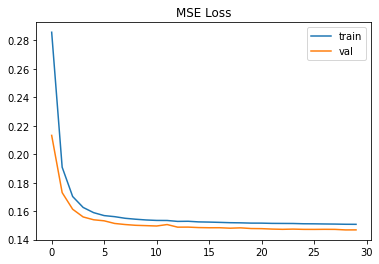

In [ ]:
#encoder, decoder = full_train(device, train_loader, val_loader)

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#path_save_enc = '/content/drive/MyDrive/encoder.weights'
#torch.save(encoder.state_dict(), path_save_enc)

#path_save_dec = '/content/drive/MyDrive/decoder.weights'
#torch.save(decoder.state_dict(), path_save_dec)

In [24]:
encoder, decoder = full_train(device, train_loader, val_loader)

Downloading...
From: https://drive.google.com/uc?id=1-1S-lKwIAhYG-gbeQzHGDqDzozDHQg24
To: /content/encoder.weights
100% 791k/791k [00:00<00:00, 91.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--vmzcti5QhizDLkNm-ZhCkf-silDYtK
To: /content/decoder.weights
100% 788k/788k [00:00<00:00, 169MB/s]


In [25]:
score = classification_score(encoder, train_dataset, val_dataset, device)
assert score > 0.39
score

  0%|          | 0/5000 [00:00<?, ?it/s]

      Iter       Train Loss   Remaining Time 
         1           2.0939            9.49m
         2           1.9401            9.26m
         3           1.8213            9.06m
         4           1.7212            8.88m
         5           1.6297            8.68m
         6           1.5487            8.48m
         7           1.4750            8.29m
         8           1.4078            8.09m
         9           1.3505            7.90m
        10           1.2943            7.70m
        20           0.9142            5.76m
        30           0.6820            3.84m
        40           0.5290            1.93m
        50           0.4257            0.00s


  0%|          | 0/10000 [00:00<?, ?it/s]

0.394

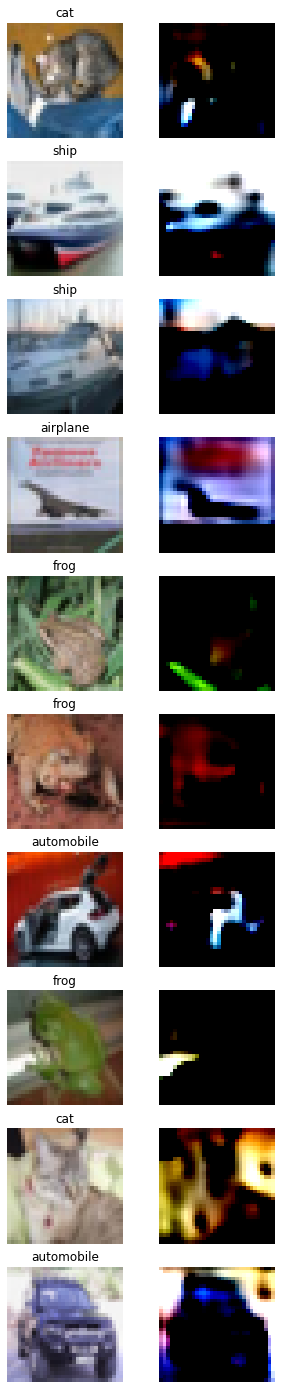

In [26]:
encoder.eval()
decoder.eval()
plt.figure(figsize=(5, 25))
for index, (image, label) in enumerate(val_loader):
    plt.subplot(10, 2, index*2+1)
    plt.imshow(denormalize_image(image)[0].permute(1, 2, 0))
    plt.axis('off')
    plt.title(text_labels[label])
    plt.subplot(10, 2, index*2+2)
    image = image.to(device)
    with torch.no_grad():
        emb = encoder(image)
        rec = decoder(emb).cpu()
    plt.imshow(denormalize_image(rec)[0].permute(1, 2, 0))
    plt.axis('off')
    if index == 9: break

### Задание 2. FID дистанция между классами CIFAR10 (3 балла)

В этой части хочется чтобы вы, используя bottleneck репрезентации от AE обученного в прошлой части посчитали FID дистанцию между различными классами CIFAR10 на **валидационной** выборке

За копию кода из сети будем снимать баллы

Напишите функцию get_representations, которая возвращает defaultdict, где ключ — это номер класса, значение — это список эмбеддингов, полученных из энкодера.

In [27]:
def get_representations(dataloader, encoder, device):
    representations = defaultdict(list)
    ### BEGIN SOLUTION
    for batch_image, batch_label in dataloader:
      for label in range(10):
        if label in batch_label:
          representations[label].append(encoder(batch_image[batch_label == label].to(device)).detach().cpu())
    return representations
    ### END SOLUTION

In [28]:
representations = get_representations(val_loader, encoder, device)
assert len(representations) == 10
assert len(representations[0]) == 1000
assert type(representations[0][0]) == torch.Tensor
#assert representations[0][0].shape == (256, )

Напишите функцию расчета FID
$$\text{FID}=\left\|\mu_{r}-\mu_{g}\right\|^{2}+T_{r}\left(\Sigma_{r}+\Sigma_{g}-2\left(\Sigma_{r} \Sigma_{g}\right)^{1 / 2}\right)$$

In [29]:
def calculate_fid(repr1, repr2):
    ### BEGIN SOLUTION
    from scipy import linalg
    if len(repr1.shape) == 3:
        repr1 = repr1.squeeze(1)
    if len(repr2.shape) == 3:
        repr2 = repr2.squeeze(1)    
    mu1 = np.mean(repr1, axis=0)
    mu2 = np.mean(repr2, axis=0)
    sigma1 = np.cov(repr1, rowvar=False)
    sigma2 = np.cov(repr2, rowvar=False)
    cov_root, _ = linalg.sqrtm(np.dot(sigma1, sigma2), disp=False)  
    cov_root = cov_root.real
    part1 = np.dot((mu1-mu2), (mu1-mu2))
    FID = part1 + np.trace(sigma1 + sigma2) - 2 * np.trace(cov_root)
    ### END SOLUTION
    return FID

In [30]:
repr1 = torch.stack(representations[0], dim=0).cpu().numpy()
repr2 = torch.stack(representations[9], dim=0).cpu().numpy()

In [31]:
calculate_fid(repr1, repr2)

46.67658367704075

In [32]:
heatmap = np.zeros((10, 10))
for label_from in trange(10):
    for label_to in range(10):
        fid = calculate_fid(
            torch.stack(representations[label_from], dim=0).cpu().numpy(),
            torch.stack(representations[label_to], dim=0).cpu().numpy()
        )
        heatmap[label_from, label_to] = fid
assert heatmap.shape == (10, 10)
assert np.all(heatmap + 1e-5 > 0)
airplane_ship = heatmap[0, 8]
airplane_frog = heatmap[0, 6]
truck_automobile = heatmap[9, 1]
truck_dog = heatmap[9, 5]
assert airplane_ship < airplane_frog
assert truck_automobile < truck_dog

  0%|          | 0/10 [00:00<?, ?it/s]

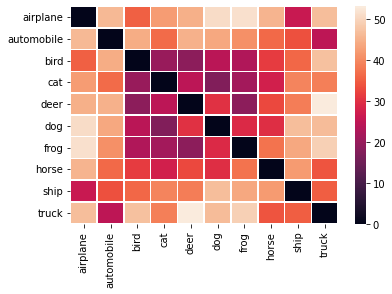

In [33]:
sns.heatmap(
    heatmap, 
    linewidth=0.5, 
    xticklabels=text_labels, 
    yticklabels=text_labels
)
plt.show()

## Задание 3 (3 балла)

Выберите ваш любимый датасет с кошками и собаками и посчитайте FID между двумя классами на новых данных, используя репрезентацию с уже обученного AE

хинт: если любимого датасета с кошками и собаками нет, можно вырезать эти классы из имажнета

хинт: если вам оооочень не нравятся кошки и собаки, то можете выбрать другие два противоположных класса

In [ ]:
# YOUR CODE HERE

In [34]:
!wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
# if the link does not work, you can download the dataset manually from https://disk.yandex.ru/d/nuyCNaDrE1Bq0w
!unzip -n data.zip 

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/dog.5499.jpg      
  inflating: train/dog.55.jpg        
  inflating: train/dog.550.jpg       
  inflating: train/dog.5500.jpg      
  inflating: train/dog.5501.jpg      
  inflating: train/dog.5502.jpg      
  inflating: train/dog.5503.jpg      
  inflating: train/dog.5504.jpg      
  inflating: train/dog.5505.jpg      
  inflating: train/dog.5506.jpg      
  inflating: train/dog.5507.jpg      
  inflating: train/dog.5508.jpg      
  inflating: train/dog.5509.jpg      
  inflating: train/dog.551.jpg       
  inflating: train/dog.5510.jpg      
  inflating: train/dog.5511.jpg      
  inflating: train/dog.5512.jpg      
  inflating: train/dog.5513.jpg      
  inflating: train/dog.5514.jpg      
  inflating: train/dog.5515.jpg      
  inflating: train/dog.5516.jpg      
  inflating: train/dog.5517.jpg      
  inflating: train/dog.5518.jpg      
  inflating: train/dog.5519.jpg      
  inflating: train/d

In [35]:
import torch
from torchvision.models.inception import inception_v3
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
from copy import deepcopy
import matplotlib.pyplot as plt
from skimage.transform import resize
import requests
from os import mkdir
from os.path import exists
import shutil

from tqdm import tqdm
from skimage.io import imread
import PIL.Image as Image
import os
import numpy as np

import time

In [36]:
if not exists('catdog/'):
        mkdir('catdog/')
if not exists('catdog/cat'):
        mkdir('catdog/cat')
if not exists('catdog/dog'):
        mkdir('catdog/dog')
for fname in tqdm(os.listdir('train')):
    if fname.startswith("cat"):
        sourcePath = 'train/' + fname
        destinationPath = 'catdog/cat/' + fname[4:]
        shutil.copy(sourcePath, destinationPath)
    if fname.startswith("dog"):
        sourcePath = 'train/' + fname
        destinationPath = 'catdog/dog/' + fname[4:]
        shutil.copy(sourcePath, destinationPath)

100%|██████████| 25000/25000 [00:04<00:00, 5850.51it/s]


In [37]:
batch_size = 16
input_size = 32
num_classes = 2
num_epochs = 10

means = np.array((0.4914, 0.4822, 0.4465))
stds = np.array((0.2023, 0.1994, 0.2010))

In [38]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop((input_size, input_size)),
    transforms.RandomRotation([-30, 30]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

transform_test = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    #transforms.Normalize(means, stds),
])

In [39]:
train_dataset = datasets.ImageFolder('catdog/', transform=transform_train)
test_dataset = datasets.ImageFolder('catdog/', transform=transform_test)

In [40]:
indices = np.random.permutation(len(train_dataset))
valid_split = 5000
test_split = 10000
training_indices, valid_indices, test_indices = indices[test_split:], indices[:valid_split], indices[valid_split:test_split]

train_sampler = SubsetRandomSampler(training_indices)
valid_sampler = SubsetRandomSampler(valid_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [42]:
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size, 
                                              sampler=train_sampler, 
                                              num_workers=0)
valid_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=batch_size, 
                                           sampler=valid_sampler, 
                                           num_workers=0)
test_batch_gen = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size,
                                          sampler=test_sampler, 
                                          num_workers=0)

In [43]:
representations_new = get_representations(valid_batch_gen, encoder, device)

In [44]:
repr1 = torch.cat(representations_new[0], dim=0).cpu().numpy()
repr2 = torch.cat(representations_new[1], dim=0).cpu().numpy()

In [45]:
calculate_fid(repr1, repr2)

4.2067066605799255

## Задание 4 (1 балл)

Вы отлично поработали и, скорее всего, в процессе выполнения этих задач у вас появились идеи о том, как еще можно решать подобные проблемы. 

Здесь вы можете описать способы которые вам хотелось бы попробовать если бы у вас было больше времени, или показать статьи которые вы читали, которые решают такие задачи.

Дополнительно, необходимо приложить сюда какой-нибудь смешной мем про генеративные модели за последние два года. Если мем будет не смешным, то баллы придется снять.

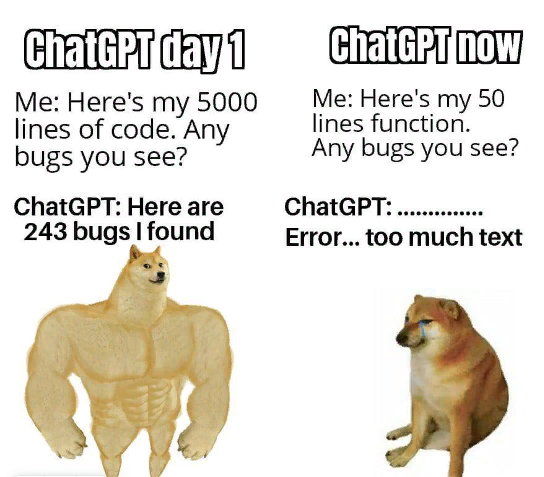